In [74]:
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
from IPython.display import display, Image

import os
import pandas as pd
import numpy as np
from six.moves import cPickle as pickle
from six.moves.urllib.request import urlretrieve
from scipy import spatial
import math
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
from semantic_similarity import similarity
from textblob import TextBlob

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [137]:
import seaborn 
print(seaborn.__version__)

0.7.1


# The training data and models
We will import the traning data, preprocess the data, extract features, and try different machine learnig method.

### Load training data
The training and testing data are downloaded from 'https://www.kaggle.com/c/quora-question-pairs/data'

In [3]:
#import the trainnig data
text_data = pd.read_csv('train.csv')
print(len(text_data))
text_data.head(10)

404290


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [4]:
# get the train lable
label = text_data['is_duplicate']
label.head(10)

0    0
1    0
2    0
3    0
4    0
5    1
6    0
7    1
8    0
9    0
Name: is_duplicate, dtype: int64

In [5]:
text_data100 = text_data[:100]

In [48]:
print(text_data.loc[0,'question1'])

What is the step by step guide to invest in share market in india?


In [51]:
str1 = str(text_data.loc[0, 'question1'])
str1

'What is the step by step guide to invest in share market in india?'

In [55]:
str1 = 'hi, this is micheal. hello ?'

In [56]:
len(str1.split())

6

### Text analysis

In [15]:
train_qs = pd.Series([x for x in text_data100['question1']] + text_data100['question2'].tolist()).astype(str)
train_qs[0]

'What is the step by step guide to invest in share market in india?'

In [24]:
len(train_qs[0])

66

In [14]:
text_data100.loc[0,'question1']

'What is the step by step guide to invest in share market in india?'

In [103]:
# generate a dataframe for text length analysis
def text_analysis(df):
    length1 = []
    length2 = []
    for i in range(len(df)):
        list_tmp = []
        str1 = str(df.loc[i, 'question1'])
        str2 = str(df.loc[i, 'question2'])
        length1.append(len(str1.split()))
        length2.append(len(str2.split()))
        
    dic = {'length1': length1, 'length2':length2, 'label':label}
    return pd.DataFrame(dic)


In [43]:
train_analysis.head()

,label,length1,length2
0,0,14,12
1,0,8,13
2,0,14,10
3,0,11,9
4,0,13,7


In [104]:
train_analysis = text_analysis(text_data)
# get the word length of all question lengths
qs_total = train_analysis['length1'].append(train_analysis['length2'])

# word length of all dupliate questions 
qs_dup = train_analysis[train_analysis.label == 1]['length1'].append(
    train_analysis[train_analysis.label == 1]['length2'])

#word length of all non dupliate questions 
qs_NONdup = train_analysis[train_analysis.label == 0]['length1'].append(
    train_analysis[train_analysis.label == 0]['length2'])

# word length difference of all dupliate questions 
len_diff_dup = [abs(train_analysis.loc[i,'length1'] - train_analysis.loc[i, 'length2']) 
                for i in range(len(train_analysis)) 
                if train_analysis.loc[i, 'label'] == 1]  
len_diff_dup = pd.Series(len_diff_dup)

#word length difference of all non dupliate questions 
len_diff_NONdup = [abs(train_analysis.loc[i,'length1'] - train_analysis.loc[i, 'length2']) 
                for i in range(len(train_analysis)) 
                   if train_analysis.loc[i, 'label'] == 0]
len_diff_NONdup = pd.Series(len_diff_NONdup)

C:\Users\Xu Wen Tao\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


mean-total 11.06 std-total 5.88 max-total 237.00 
mean-duplicate 9.85 std-duplicate 4.16 max-duplicate 80.00 
mean-non duplicate 11.77 std-non duplicate 6.59 max-non duplicate 237.00 


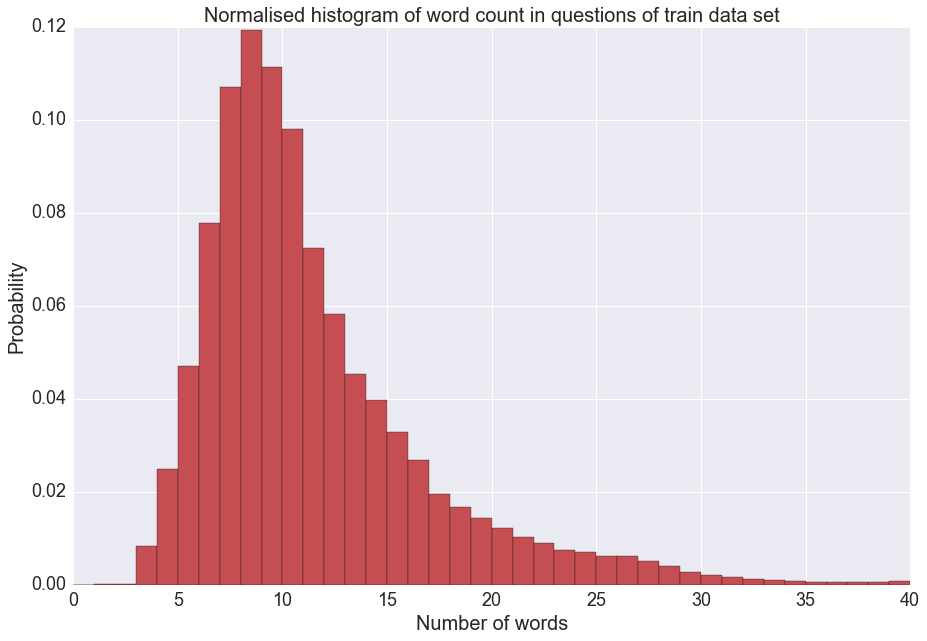

In [105]:
import seaborn as sns
pal = sns.color_palette()

#plot the word count distributions
plt.figure(figsize=(15, 10))
plt.hist(qs_total, bins=40, range=[0, 40], color=pal[2],normed=True)
plt.title('Normalised histogram of word count in questions of train data set', fontsize=20)
plt.legend()
plt.xlabel('Number of words', fontsize=20)
plt.ylabel('Probability', fontsize=20)
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18

# the statistics of word count 
print('mean-total {:.2f} std-total {:.2f} max-total {:.2f} '.format(qs_total.mean(), 
                          qs_total.std(), qs_total.max()))
print('mean-duplicate {:.2f} std-duplicate {:.2f} max-duplicate {:.2f} '.format(qs_dup.mean(), 
                          qs_dup.std(), qs_dup.max()))
print('mean-non duplicate {:.2f} std-non duplicate {:.2f} max-non duplicate {:.2f} '.format(
        qs_NONdup.mean(), qs_NONdup.std(), qs_NONdup.max()))

mean-duplicate 2.42 std-duplicate 2.69 max-duplicate 39.00 
mean-non duplicate 4.44 std-non duplicate 5.60 max-non duplicate 223.00 


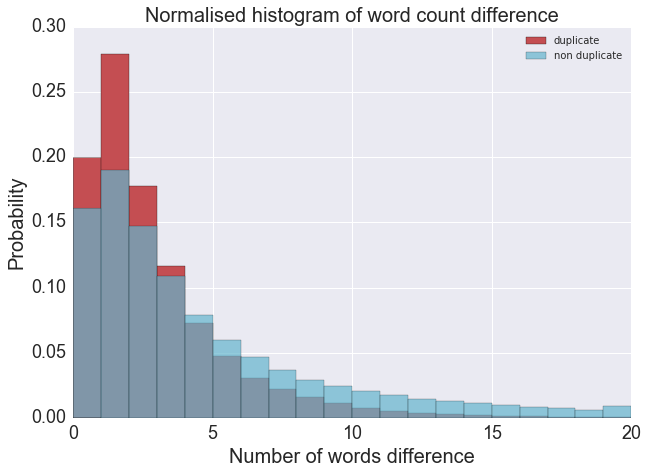

In [107]:

# plot the word count differnece for duplicate and non duplicate question pairs
plt.figure(figsize=(10, 7))
plt.hist(len_diff_dup, bins=20, range=[0, 20], color=pal[2],normed=True, label='duplicate')
plt.hist(len_diff_NONdup, bins=20, range=[0, 20], color=pal[5],normed=True,alpha=0.7,
         label='non duplicate')
plt.title('Normalised histogram of word count difference', fontsize=20)
plt.legend()
plt.xlabel('Number of words difference', fontsize=20)
plt.ylabel('Probability', fontsize=20)


mpl.rcParams.update({'font.size': 20})


# print word count difference statistics
print('mean-duplicate {:.2f} std-duplicate {:.2f} max-duplicate {:.2f} '.format(
        len_diff_dup.mean(), len_diff_dup.std(), len_diff_dup.max()))
print('mean-non duplicate {:.2f} std-non duplicate {:.2f} max-non duplicate {:.2f} '.format(
        len_diff_NONdup.mean(), len_diff_NONdup.std(), len_diff_NONdup.max()))

In [ ]:
pal = sns.color_palette()

## Preprocess the data.
In this part, we will preprocess the train data. Also we will generate a word vector dictionary and word probability dictionary for feature enginnering use. 

In [1]:
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'no

These stop words from nltk packages are too much, for example, 'not' should be kept for calculating polarity difference.  so we use our own stop words list.  
We now preprocess our data, including removing punctuations, numbers, stop words, and lowercase all words. Store the questions in a list of a list. 


In [27]:
# remove stop words and punctuation and store 'questoin1' and 'question2' in a 2D list
#this stopwords list is used in solution of version 1
stopwords = ['the', 'a', 'an', 'is', 'are', 'was', 'were', 'am', 'which','what','how']
import string
def remove_stopwords(df):
    
    list12 = []
    for i in range(len(df)):
        list_tmp = []
        str1 = str(df.loc[i, 'question1'])
        str2 = str(df.loc[i, 'question2'])
        
        translator = str.maketrans('', '', string.punctuation)
        #remove punctuation
        str1 = str1.translate(translator)
        str2 = str2.translate(translator)

        #remove stop words
        words1 = [x for x in str1.split() if x not in stopwords]
        words2 = [x for x in str2.split() if x not in stopwords]
                        
        # Remove single-character word (mostly punctuation)
        #words1 = [word for word in words1 if len(word) > 1]
        #words2 = [word for word in words2 if len(word) > 1]
        
        # Remove numbers
        words1 = [word for word in words1 if not word.isnumeric()]
        words2 = [word for word in words2 if not word.isnumeric()]
        
        # Lowercase all words (default_stopwords are lowercase too)
        words1 = [word.lower() for word in words1]
        words2 = [word.lower() for word in words2]
        
        list_tmp.append(words1)
        list_tmp.append(words2)
        #create a 2 dimensional list
        list12.append(list_tmp)
    return list12


In [8]:
# get the preprocessed data stored in a list.
list12 = remove_stopwords(text_data)
print(list12[0:10])

[[['what', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', 'in', 'india'], ['what', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market']], [['what', 'story', 'of', 'kohinoor', 'kohinoor', 'diamond'], ['what', 'would', 'happen', 'if', 'indian', 'government', 'stole', 'kohinoor', 'kohinoor', 'diamond', 'back']], [['how', 'can', 'i', 'increase', 'speed', 'of', 'my', 'internet', 'connection', 'while', 'using', 'vpn'], ['how', 'can', 'internet', 'speed', 'be', 'increased', 'by', 'hacking', 'through', 'dns']], [['why', 'i', 'mentally', 'very', 'lonely', 'how', 'can', 'i', 'solve', 'it'], ['find', 'remainder', 'when', 'math2324math', 'divided', 'by']], [['which', 'one', 'dissolve', 'in', 'water', 'quikly', 'sugar', 'salt', 'methane', 'and', 'carbon', 'di', 'oxide'], ['which', 'fish', 'would', 'survive', 'in', 'salt', 'water']], [['astrology', 'i', 'capricorn', 'sun', 'cap', 'moon', 'and', 'cap', 'risingwhat', 'does', 'that', 'say', 'about', 'me'], ['

### Word vector dictionary
We will use the pretrained word vector for converting each sentence into vector space. The word vector file **paragram-phrase-XXL.txt** is downloaded from http://ttic.uchicago.edu/~wieting/

In [150]:
import sys
def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent

def maybe_download(filename, expected_bytes, url, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join('.', filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

In [151]:
last_percent_reported = None
url = 'http://ttic.uchicago.edu/~wieting/'
_ = maybe_download('paragram-phrase-XXL.txt', 161847918, url)

Attempting to download: paragram-phrase-XXL.txt
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified .\paragram-phrase-XXL.txt


In [9]:
# each line conains a word and 1x300 vector
vector_table = pd.read_table('paragram-phrase-XXL.txt', header = None)

#store the vector in a dictionary, key is the word, value is the vector
wordvector = {}
for i in range(len(vector_table)):
    line = vector_table[0][i].split()
    wordvector[line[0]] = [float(x) for x in line[1:]]

In [10]:
#save the wordvector, to reload the saved wordvector, then use:
# with open('wordvecotr.pickle', 'rb') as f:
#        wordvector = pickle.load(f)
with open('wordvector.pickle','wb') as f:
    pickle.dump(wordvector, f, pickle.HIGHEST_PROTOCOL)


In [92]:
with open('wordvector.pickle', 'rb') as f:
        wordvector = pickle.load(f)

### Word probability dictionary 
Different word have different weighting in a sentence. Usually the more frequent of a word, the less import of the word in a sentence. The word probability is calculated based on word frequency file **count_1w.txt**, which get the frequency based on text corpus of 1,024,908,267,229 words. This file is downloaded from http://norvig.com/ngrams/  

In [152]:
last_percent_reported = None
url = 'http://norvig.com/ngrams/'
_ = maybe_download('count_1w.txt', 4956241, url)

Attempting to download: count_1w.txt
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified .\count_1w.txt


In [9]:
word_frenq = pd.read_table('count_1w.txt', header = None)

#word probability dictionary
word_prob = {}
for i in range(len(word_frenq)):
    word_prob[word_frenq[0][i]] = float(word_frenq[1][i])/1024908267229.0


In [93]:
# let us see 2 exmaples of word probability
print(word_prob['guide'])
print(word_prob['the'])

0.0002081930781736233
0.02257358234074099


It can be seen that 'the' has much a higher probability than 'guide', whihc meets our expectations according to our common knowleadge.

## Feature engineering
Next we will calculate features of each pair questions. 

In [94]:
#**************************cosin similarity*************************************************************#
# calculate cosin similarity

#calculate the sentence vector by adding weighted word vector 
# weight a= a/(a+p(w)) with a a parameter(default 10-4) and p(w) the (estimated) word probability
#weight is selected according to the paper: 'A Simple but tough-to-beat baseline for sentence embeddings'


def feature_vector(words, wordvector = wordvector, word_prob = word_prob, a = 0.001, num_features = 300):
        '''
        word is the list for sentence
        calculate average of all words vectors 
        and the weighted words vectors in a given sentence
        '''
        
        #weighted sentence vector
        wtd_featureVec = np.zeros((num_features,), dtype="float32")
        #average sentence vector
        avg_featureVec = np.zeros((num_features,), dtype="float32")
        nwords = 0

        #list containing names of words in the vocabulary
        
        for word in words:
            if word in wordvector.keys() and word in word_prob.keys():
                nwords = nwords+1
                avg_featureVec = np.add(avg_featureVec, wordvector[word])
                wt = np.divide(a,np.add(a,word_prob[word]))
                wtd_featureVec = np.add(wtd_featureVec, np.multiply(wordvector[word],wt))

        if(nwords>0):
            avg_featureVec = np.divide(avg_featureVec, nwords)
        return avg_featureVec, wtd_featureVec
    
def get_cosin_simularity(sent1, sent2):
    '''
    input two sentences in the form of list,
    output similirity according to weighted word vector and average word vector
    '''
    if len(sent1) == 0 or len(sent2) == 0:
        return 0,0
    #get vector for two sentences 
    sent1_avg_vector, sent1_wtg_vector = feature_vector(sent1)
    sent2_avg_vector, sent2_wtg_vector = feature_vector(sent2)
    
    avg_similarity = 1 - spatial.distance.cosine(sent1_avg_vector,sent2_avg_vector)
    wtg_similarity = 1 - spatial.distance.cosine(sent1_wtg_vector,sent2_wtg_vector)
    
    # A few similarity returns NaN (65 of 404290), possibly becuase the some word vector 
    # are not in the dictionary or becuase some computer genreted question pairs have only 
    # stop words. we just assign them as 0.5.  
    if math.isnan(avg_similarity):
        avg_similarity = 0.5
    if math.isnan(wtg_similarity):
        wtg_similarity = 0.5
    
    return avg_similarity, wtg_similarity


#**************************Length of longest common words*************************************************#
def f_lcword_length(a, b):
    '''
    return the lenght of the longest common words of list a and list b
    '''
    table = [[0] * (len(b) + 1) for _ in range(len(a) + 1)]
    l = 0
    for i, ca in enumerate(a, 1):
        for j, cb in enumerate(b, 1):
            if ca == cb:
                table[i][j] = table[i - 1][j - 1] + 1
                if table[i][j] > l:
                    l = table[i][j]
    return l

#**************************Polarity difference**********************************************************#
def f_polarity_diff(a,b):
    '''
    given two stirngs, return the polarity difference
    '''
    blob1 = TextBlob(a)
    blob2 = TextBlob(b)
    return abs((blob1.sentiment.polarity - blob2.sentiment.polarity)/2.0)

#**************************Ration of length**********************************************************#
def f_ratio_length(a,b):
    '''
    return the ratio of the length of the short sentence to the long sentence 
    '''
    if len(a) < len(b):
        return float(len(a)/len(b))
    else:
        return float(len(b)/len(a))

    
#**************************word match share**********************************************************#
def word_match_share(a, b):
    
    # return the word match share
    if len(a) == 0 or len(b) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    la = 0
    lb = 0
    for word in a:
        if word in b:
            la += 1
    for word in b:
        if word in a:
            lb += 1
    return float((la + lb))/(len(a) + len(b))


#**************************tfidf word match share*****************************************************#
def tfidf_word_match_share(a,b):
    # return weighted word match share
    if len(a) == 0 or len(b) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    la = 0
    lb = 0
    la_tot = 0
    lb_tot = 0
    for word in a:
        if word in word_prob.keys():
            la_tot += 1.0/word_prob[word]
            if word in b:
                la += 1.0/word_prob[word]
        #if word not in word_prob keys, meaning the word is rare, should have a large weight
        else:
            la_tot += 500000.0
            if word in b:
                la += 500000.0
    for word in b:
        if word in word_prob.keys():
            lb_tot += 1.0/word_prob[word]
            if word in a:
                lb += 1.0/word_prob[word]
        #if word not in word_prob keys, meaning the word is rare, should have a large weight
        else:
            lb_tot += 500000.0
            if word in a: 
                lb += 500000.0
    return (la + lb)/(la_tot + lb_tot)
#************************************************************************************************#

In [340]:
# generate features

def generate_feature(l = list12):
    list_total = [[]]
    bwo = []
    blo = []
    jaccard_sim = []
    cosine_sim = []
    lcw_length = []
    semantic_sim = []
    polarity_diff = []
    ratio_of_length = []
    avg_sim = []
    wtg_sim = []
    word_share = []
    tfidf_word_share = []
    for i in range(len(list12)):
        #Bags of words overlap
        l_mut = [x for x in list12[i][0] if x in list12[i][1]]
        l_max_length = np.max([len(list12[i][0]),len(list12[i][1])])
        bwo.append(len(l_mut)/float(l_max_length))
                              
        #Bags of lemmatised words overlap
        x1_lemmas = [wnl.lemmatize(x) for x in list12[i][0]]
        x2_lemmas = [wnl.lemmatize(x) for x in list12[i][1]]
        l_mut_lemmas = [x for x in x1_lemmas if x in x2_lemmas]
        blo.append(len(l_mut_lemmas)/float(l_max_length))
        
        #Jaccard similarity of sets of lemmas
        s_mut_lemmas = set(l_mut_lemmas)
        s_add = set(x1_lemmas + x2_lemmas)
        jaccard_sim.append(len(s_mut_lemmas)/float(len(s_add)))
                              
        #Cosine similarity of vectors of lemmatised effective words
         #first convert the list to 2 strings                     
        str1 = ' '.join(x1_lemmas)
        str2 = ' '.join(x2_lemmas)
        vect = TfidfVectorizer(min_df=1)
        tfidf = vect.fit_transform([str1,str2])
        sim = (tfidf * tfidf.T)[0,1]
        cosine_sim.append(sim)
                           
        #the lenght of the longest common words of 2 lists
        lcw_length.append(f_lcword_length(list12[i][0], list12[i][1]))
                              
        #semantic similarity 
        semantic_sim.append(similarity(str1, str2, False))
        
        #polarity difference
        polarity_diff.append(f_polarity_diff(str1,str2))
        
        #ratio of sentence length
        ratio_of_length.append(f_ratio_length(list12[i][0], list12[i][1]))
        
        #Average word2vec cosine similarity and
        #weighted word2vec cosine similartiy
        avg, wtg = get_cosin_simularity(list12[i][0], list12[i][1])
        avg_sim.append(avg)
        wtg_sim.append(wtg)
        
        #word match share
        word_share.append(word_match_share(list12[i][0], list12[i][1]))
                              
        #weighted word match share
        tfidf_word_share.append(tfidf_word_match_share(list12[i][0], list12[i][1]))
        
    di = {'bwo': bwo, 'blo':blo, 'jaccard_sim':jaccard_sim, 'cosine_sim':cosine_sim, 'lcw_length':lcw_length, 
          'semantic_sim':semantic_sim, 'polarity_diff':polarity_diff, 'ratio_of_length':ratio_of_length,
         'avg_sim':avg_sim, 'wtg_sim':wtg_sim, 'word_share': word_share, 'tfidf_word_share':tfidf_word_share}
    
    return pd.DataFrame(di) 
        
    

In [ ]:
df = generate_feature(list12)

This process takes about 36 hours in my computer!

### Process the feature numbers. 

In [20]:
df.describe()

C:\Users\WENTAO\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,blo,bwo,cosine_sim,jaccard_sim,lcw_length,polarity_diff,ratio_of_length,semantic_sim,avg_sim,wtg_sim,word_share,tfidf_word_share
count,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404244.000000,404290.000000,404290.000000,404290.000000,404290.000000
mean,0.453670,0.436412,0.390857,0.374079,2.705546,0.079750,0.757382,0.576823,0.646459,0.670799,0.483282,0.453122
std,0.256989,0.256522,0.252160,0.249002,2.357799,0.129131,0.197437,0.211055,0.241725,0.244313,0.260361,0.390814
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.316336,-0.316336,0.000000,0.000000
25%,0.250000,0.250000,0.195582,0.181818,1.000000,0.000000,0.625000,NaN,0.513990,0.542589,0.285714,0.040357
50%,0.428571,0.421053,0.345770,0.333333,2.000000,0.000000,0.800000,NaN,0.691798,0.725413,0.476190,0.391385
75%,0.650000,0.625000,0.572739,0.545455,3.000000,0.125000,0.900000,NaN,0.831434,0.857683,0.666667,0.880919
max,1.000000,1.000000,1.000000,1.000000,42.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


From the above talbe we can see there are 404290-404244 = 46 NaN in 'semantic_sim', we replace the None with 0.5, which is near to the mean.

In [ ]:
for i in range(len(df)):
    if math.isnan(df.loc[i, 'semantic_sim']):
        df.loc[i, 'semantic_sim'] = 0.5
        i += 1

In [22]:
df.describe()

,blo,bwo,cosine_sim,jaccard_sim,lcw_length,polarity_diff,ratio_of_length,semantic_sim,avg_sim,wtg_sim,word_share,tfidf_word_share
count,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000
mean,0.453670,0.436412,0.390857,0.374079,2.705546,0.079750,0.757382,0.576814,0.646459,0.670799,0.483282,0.453122
std,0.256989,0.256522,0.252160,0.249002,2.357799,0.129131,0.197437,0.211045,0.241725,0.244313,0.260361,0.390814
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.316336,-0.316336,0.000000,0.000000
25%,0.250000,0.250000,0.195582,0.181818,1.000000,0.000000,0.625000,0.426355,0.513990,0.542589,0.285714,0.040357
50%,0.428571,0.421053,0.345770,0.333333,2.000000,0.000000,0.800000,0.571188,0.691798,0.725413,0.476190,0.391385
75%,0.650000,0.625000,0.572739,0.545455,3.000000,0.125000,0.900000,0.737029,0.831434,0.857683,0.666667,0.880919
max,1.000000,1.000000,1.000000,1.000000,42.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
# Now we have all the features we need, let us save the dataframe as dfTrain.csv
df.to_csv('dfTrain.csv')

In [28]:
#check if all parameters are Guassian like.
def distribution(data, transformed = False):
    """
    Visualization code for displaying skewed distributions of features
    """
    
    # Create figure
    fig = plt.figure(figsize = (11,11));

    # Skewed feature plotting
    for i, feature in enumerate(data.columns):
        ax = fig.add_subplot(4, 4, i+1)
        ax.hist(data[feature], bins = 20)
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 8)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")
        %ax.set_ylim((-2, 6))
        %ax.set_yticks([-1, 0, 1])
        %ax.set_yticklabels([-1, 0, 1])

    # Plot aesthetics
    if transformed:
        fig.suptitle("Log-transformed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)
    else:
        fig.suptitle("Feature Distributions of Question Pairs", \
            fontsize = 16, y = 1.03)

    fig.tight_layout()
    fig.show()

#######Display the n(feature_num) most important features#######
def feature_plot(importances, X_train, y_train, feature_num):
    
    # Display the n(feature_num) most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:feature_num]]
    values = importances[indices][:feature_num]

    # Creat the plot
    fig = pl.figure(figsize = (9,5))
    pl.title("Normalized Weights for First several Most Predictive Features", fontsize = 10)
    pl.bar(np.arange(feature_num), values, width = 0.2, align="center", color = '#00A000', \
          label = "Feature Weight")
    pl.bar(np.arange(feature_num) - 0.1, np.cumsum(values), width = 0.05, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    pl.xticks(np.arange(feature_num), columns)
    pl.xlim((-0.5, feature_num-0.5))
    pl.ylabel("Weight", fontsize = 8)
    pl.xlabel("Feature", fontsize = 8)
    
    pl.legend(loc = 'upper center')
    pl.tight_layout()
    pl.show() 

ERROR: Line magic function `%ax.set_ylim` not found.
ERROR: Line magic function `%ax.set_yticks` not found.
ERROR: Line magic function `%ax.set_yticklabels` not found.
ERROR: Line magic function `%ax.set_ylim` not found.
ERROR: Line magic function `%ax.set_yticks` not found.
ERROR: Line magic function `%ax.set_yticklabels` not found.
ERROR: Line magic function `%ax.set_ylim` not found.
ERROR: Line magic function `%ax.set_yticks` not found.
ERROR: Line magic function `%ax.set_yticklabels` not found.
ERROR: Line magic function `%ax.set_ylim` not found.
ERROR: Line magic function `%ax.set_yticks` not found.
ERROR: Line magic function `%ax.set_yticklabels` not found.
ERROR: Line magic function `%ax.set_ylim` not found.
ERROR: Line magic function `%ax.set_yticks` not found.
ERROR: Line magic function `%ax.set_yticklabels` not found.
ERROR: Line magic function `%ax.set_ylim` not found.
ERROR: Line magic function `%ax.set_yticks` not found.
ERROR: Line magic function `%ax.set_yticklabels` not

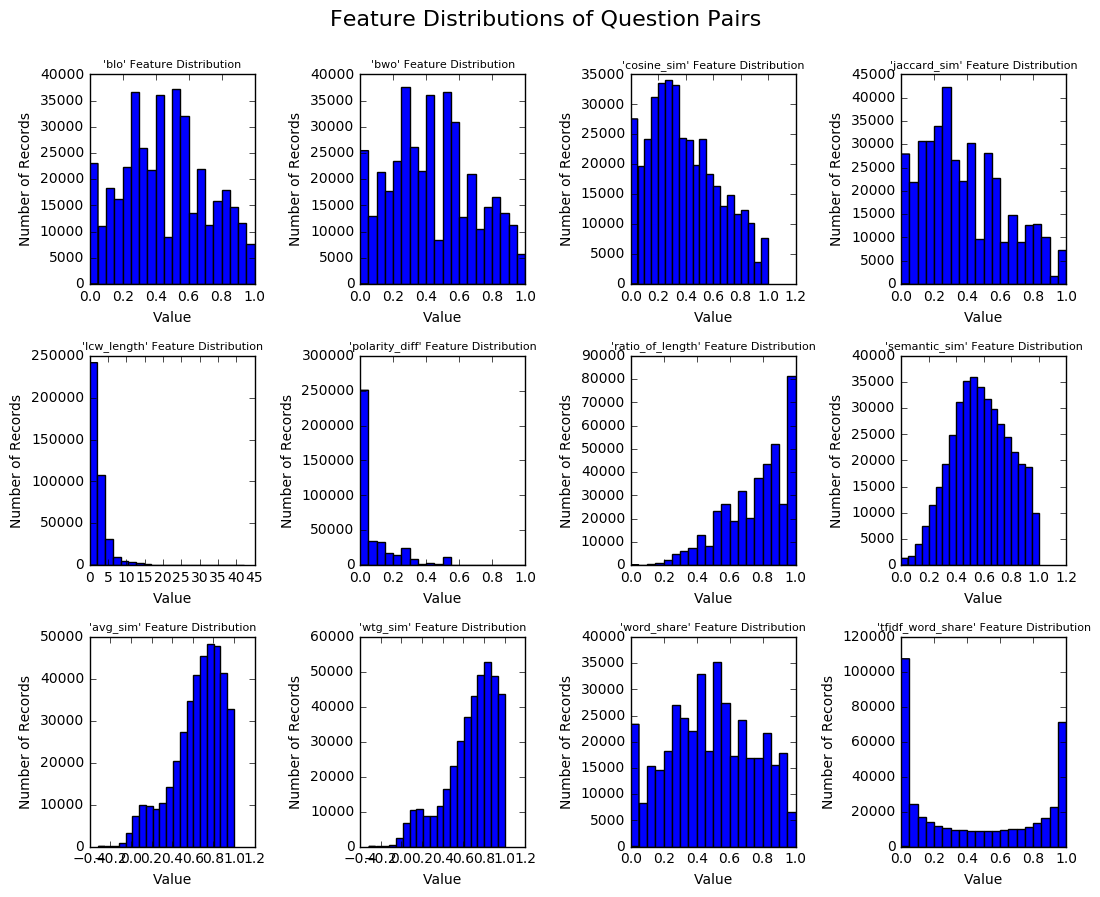

In [29]:
distribution(df)

All features except 'lcw_length' are almost between 0-1, we can standardize this feature to 0-1

In [32]:
lcw_max = np.max(df['lcw_length'])
lcw_min = np.min(df['lcw_length'])
df['lcw_length'] = df['lcw_length'].apply(lambda x: (x-lcw_min)/(lcw_max - lcw_min))

In [34]:
#Now we save the standardized dataframe to dfTrain_stand.csv
df.to_csv('dfTrain_stand.csv')

In [135]:
def distribution_of2class(df):
    '''
    plot all the features of two different classes
    '''
        
    # Create figure
    fig = plt.figure(figsize = (15,12));
    
    for i, feature in enumerate(df.columns):
        ax = fig.add_subplot(4, 3, i+1)
        # duplicate questions
        dup = df[label == 1][feature]
        # non duplicate questions 
        NONdup = df[label == 0][feature]
        # the weights term makes sure summing of all bars equals to 1
        dup_weights = np.ones_like(dup)/len(dup)
        NONdup_weights = np.ones_like(NONdup)/len(NONdup)
        
        ax.hist(dup, weights = dup_weights, bins=40, range=[0, 1], color=pal[2], normed=False, label='duplicate')
        ax.hist(NONdup, weights = NONdup_weights, bins=40, range=[0, 1], color=pal[5],  normed=False, alpha=0.7,
                label='NON duplicate')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 15)
        ax.set_xlabel("Value")
        ax.set_ylabel("Probability")
        plt.legend()
        %ax.set_ylim((-2, 6))
        %ax.set_yticks([-1, 0, 1])
        %ax.set_yticklabels([-1, 0, 1])

    # Plot aesthetics
    fig.suptitle("Normalised histogram of features for two different classes", \
        fontsize = 16, y = 1.03)
    
    fig.tight_layout()
    fig.show()

ERROR:root:Line magic function `%ax.set_ylim` not found.
ERROR:root:Line magic function `%ax.set_yticks` not found.
ERROR:root:Line magic function `%ax.set_yticklabels` not found.
ERROR:root:Line magic function `%ax.set_ylim` not found.
ERROR:root:Line magic function `%ax.set_yticks` not found.
ERROR:root:Line magic function `%ax.set_yticklabels` not found.
ERROR:root:Line magic function `%ax.set_ylim` not found.
ERROR:root:Line magic function `%ax.set_yticks` not found.
ERROR:root:Line magic function `%ax.set_yticklabels` not found.
ERROR:root:Line magic function `%ax.set_ylim` not found.
ERROR:root:Line magic function `%ax.set_yticks` not found.
ERROR:root:Line magic function `%ax.set_yticklabels` not found.
ERROR:root:Line magic function `%ax.set_ylim` not found.
ERROR:root:Line magic function `%ax.set_yticks` not found.
ERROR:root:Line magic function `%ax.set_yticklabels` not found.
ERROR:root:Line magic function `%ax.set_ylim` not found.
ERROR:root:Line magic function `%ax.set_yti

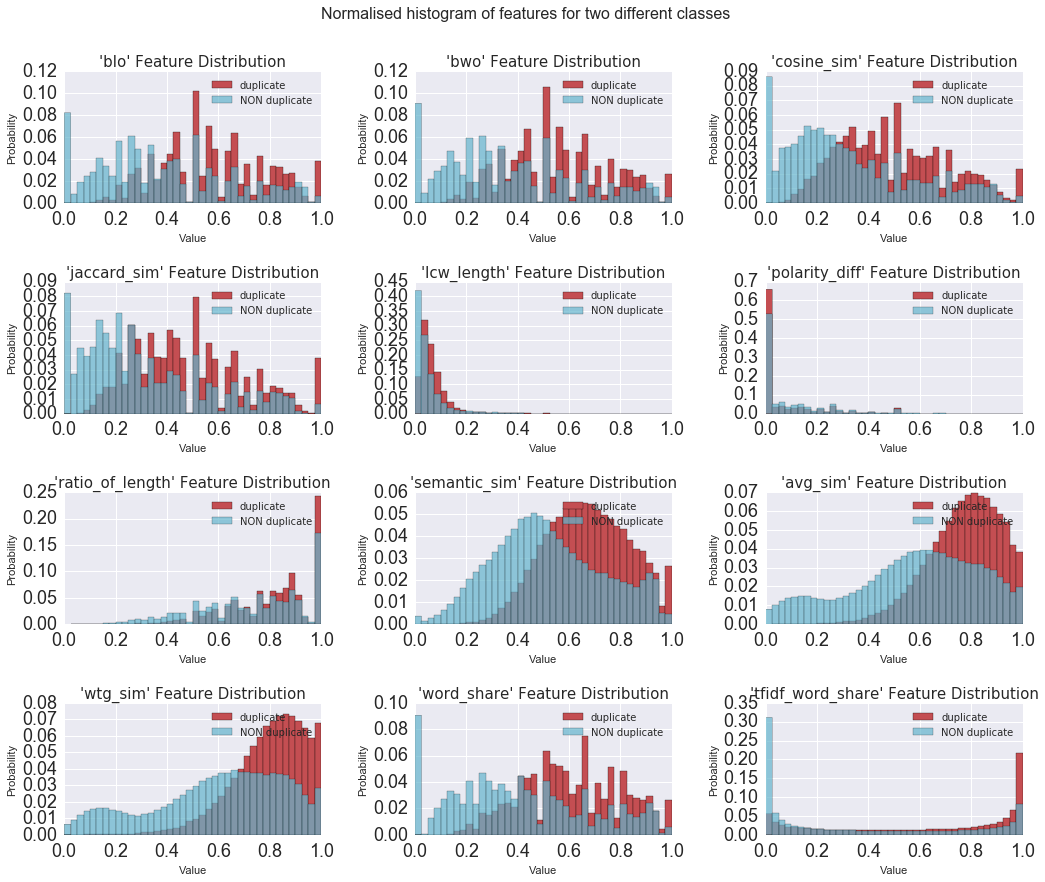

In [136]:
# distribution of each feature for different classes
distribution_of2class(df)

## Machine learning

In [109]:
df = pd.read_csv('dfTrain_stand.csv',index_col = 0)

In [3]:
df.head()

,blo,bwo,cosine_sim,jaccard_sim,lcw_length,polarity_diff,ratio_of_length,semantic_sim,avg_sim,wtg_sim,word_share,tfidf_word_share
0,0.916667,0.916667,0.910843,0.900000,0.238095,0.000,0.833333,0.958986,0.939078,0.942431,0.954545,0.961897
1,0.363636,0.363636,0.427163,0.250000,0.071429,0.000,0.545455,0.525497,0.410862,0.418249,0.470588,0.996014
2,0.333333,0.333333,0.237944,0.222222,0.047619,0.000,0.833333,0.472183,0.725194,0.723419,0.363636,0.060053
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.065,0.600000,0.175046,0.111969,0.213931,0.000000,0.000000
4,0.307692,0.307692,0.272060,0.250000,0.023810,0.000,0.538462,0.533369,0.556098,0.518459,0.400000,0.039383


In [7]:
#let's split the train data set into  training and testing data 
    X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.3, random_state=10)

In [41]:
np.mean(label)

0.369197853026293

About 36.92% of the labels are 1

### benchmark
About 37% of the labels are 1. We can guess all the predictions are 0, see what is the log loss.  

In [44]:
y_predict = np.zeros(len(y_test))
print(log_loss(y_test, y_predict))

12.7397102705


So we have the benchmark log loss equals 12.74

### SDGClassifier
let us try SGDClassifier.

In [8]:
clf = SGDClassifier(loss = 'log')
clf.fit(X_train, y_train)
y_predict = clf.predict_proba(X_test)


In [13]:
y_predict[:10,1:2]

array([[ 0.08366639],
       [ 0.11481237],
       [ 0.38133913],
       [ 0.14597372],
       [ 0.31705667],
       [ 0.48976832],
       [ 0.03519416],
       [ 0.55904761],
       [ 0.40124365],
       [ 0.37985659]])

In [14]:
print(log_loss(y_test, y_predict[:,1:2]))

0.53796791192


SGDClassifier is a little bit better than all 0 benchmark.   
Let us try kernel approximation.

In [16]:
from sklearn.kernel_approximation import RBFSampler
rbf_feature = RBFSampler(gamma=1, random_state=1)
X_train_features = rbf_feature.fit_transform(X_train)
X_test_features = rbf_feature.fit_transform(X_test)

clf = SGDClassifier(loss = 'log')
clf.fit(X_train_features, y_train)
y_predict = clf.predict_proba(X_test_features)
print(log_loss(y_test, y_predict[:,1:2]))

0.51554278846


kernel approximation also improves the result a little bit, but not much. 

### AdaBoostClassifier

In [17]:
from sklearn.ensemble import AdaBoostClassifier
clf2 = AdaBoostClassifier(random_state=2)
clf2.fit(X_train, y_train)
y_predict = clf2.predict_proba(X_test)
print(log_loss(y_test, y_predict[:,1:2]))

0.679177798023


This number is not much different from SDGClassifier, yet time efficiency is worse than SDGClassifier.

### Xgboost

In [67]:
# xgb
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=100)

predict = bst.predict(d_valid)
loss = log_loss(y_test, predict)
print('log loss is {}'.format(loss))

[0]	train-logloss:0.687799	valid-logloss:0.687841
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.523157	valid-logloss:0.524701
[200]	train-logloss:0.505592	valid-logloss:0.507428
[300]	train-logloss:0.499283	valid-logloss:0.501373
log loss is 0.49734037056521524


The prediciton is much imporved by Xgboost! We will stick to Xgboost.  

### Feature selection 
The **Feature engineering** step for train data takes more than 30 hours's calculation time. The test data size is  almost 6(2345796/404290 = 5.8) times larger than the train dataset. The expected calculation time is too large. We would like to check the importance of the features, and stick to the most important features.  


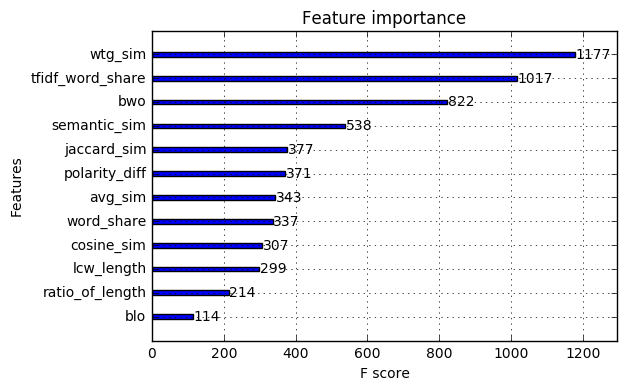

In [73]:
from xgboost import plot_importance
plot_importance(bst)


We slect the most impaortant 10 features out of the 12. By testing, i found that **semantic_sim** takes a huge amount of time compared with ohter feautres, so i also remove this feature. 

In [60]:
# remove two features, use only 10 features 
train_few = df[['wtg_sim', 'tfidf_word_share', 'bwo', 'jaccard_sim', 'polarity_diff','avg_sim', 
                   'word_share', 'cosine_sim', 'lcw_length', 'ratio_of_length']]

In [81]:
X_train, X_test, y_train, y_test = train_test_split(train_few, label, test_size=0.3, random_state=10)

d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=100)

predict = bst.predict(d_valid)
loss = log_loss(y_test, predict)
print('log loss is {}'.format(loss))

[0]	train-logloss:0.687799	valid-logloss:0.687841
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.523046	valid-logloss:0.524552
[200]	train-logloss:0.505761	valid-logloss:0.507522
[300]	train-logloss:0.49948	valid-logloss:0.501392
log loss is 0.49760136179275777


By removing 4 features, the log loss increased from 0.4973 to 0.4976, only 0.06% increase. Considering the time saved, it is worth removing the 2 features. 

### Hyper-parameter tunning
We will tune the parameters of 'eta' and 'max_depth'

In [82]:
def GridSearchXGB(X_train, y_train, X_test, y_test, eta, max_depth):
    
    """tune the best parameters of 'eta' and 'max_depth of xgb
    """
    
    params = {}
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'logloss'
    
    d_train = xgb.DMatrix(X_train, label=y_train)
    d_valid = xgb.DMatrix(X_test, label=y_test)
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    smallest_loss = 100
    bst_model = None
    for e in eta:
        for d in max_depth:
            params['eta'] = e
            params['max_depth'] = d
                #  train and predict
            model = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=300)
            predict = model.predict(d_valid)
            loss = log_loss(y_test, predict)
            if loss < smallest_loss:
                smallest_loss = loss
                bst_model = model
                bst_param = {'eta': e, 'max_depth': d}
    print("best parameters are 'eta' {}, 'max_depth' {}".format(bst_param['eta'],bst_param['max_depth']))
    print('smallest test set log loss is {}'.format(smallest_loss))
    return bst_model, bst_param

In [85]:
# parameters you want to tune 
parameters = {'eta': [0.435, 0.438, 0.44,0.443,0.445],'max_depth':[3,4,5]}

best_model, best_parameters = GridSearchXGB(X_train, y_train, X_test, y_test, parameters['eta'], parameters['max_depth'])

[0]	train-logloss:0.605863	valid-logloss:0.606744
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[300]	train-logloss:0.471715	valid-logloss:0.48351
[0]	train-logloss:0.600635	valid-logloss:0.601465
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[300]	train-logloss:0.455998	valid-logloss:0.481851
Stopping. Best iteration:
[334]	train-logloss:0.453471	valid-logloss:0.481596

[0]	train-logloss:0.595104	valid-logloss:0.595918
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
Stopping. Best iteration:
[230]	train-logloss:0.444926	valid-logloss:0.481013

[0]	train-logloss:0.605417	valid-logloss:0.606304
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stoppin

The best parameters for 'eta' and 'max_depth' are 0.443 and 5, respectively. We could have tried higher 'max_depth', but 5 already made train-loglosss apparantly lower than valid-logloss, meaning a risk of overfitting. Hence, we will not try higher 'max_depth'. 

###  Confusion matrix

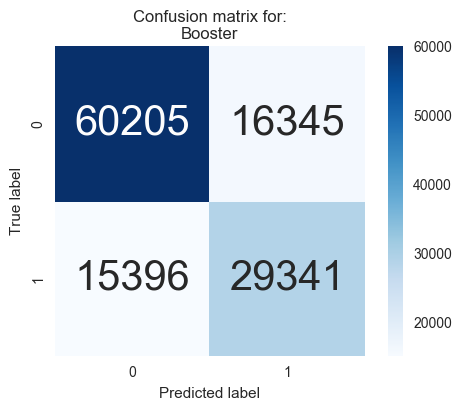

In [75]:
# let us change the probability to 0 and 1 and check the precision
# by plotting a confusion matrix using seaborn...
from sklearn.metrics import confusion_matrix
import seaborn as sns

m_test = xgb.DMatrix(X_test)

#make predicitons use the previously trained model
y_predicted = best_model.predict(m_test)
# assign the prbability to 1 if if it is > 0.5, otherwise to 0
is_duplicate_test = [1 if x > 0.5 else 0 for x in y_predicted]

# Compute confusion matrix for a model
cm = confusion_matrix(y_test, is_duplicate_test)
# Normalizaton
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

# view with a heatmap
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.0f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(best_model.__class__.__name__));


# Test data
## Preprocess
From 'sentence_similarity.ipynb' we know the important features for the prediciton, we just process these features to save time. 
thse features are **['wtg_sim', 'tfidf_word_share', 'bwo', 'jaccard_sim', 'polarity_diff','avg_sim',               'word_share', 'cosine_sim', 'lcw_length', 'ratio_of_length']**.


In [132]:
def preprocess_test(list12):
    '''process the text data to number features
    '''
    word_share = []
    avg_sim = []
    wtg_sim = []
    tfidf_word_share = []
    polarity_diff = []
    ratio_of_length = []
    jaccard_sim = []
    bwo = []
    cosine_sim = []
    lcw_length = []
    for i in range(len(list12)):
        #word match share
        word_share.append(word_match_share(list12[i][0], list12[i][1]))
                              
        #weighted word match share
        tfidf_word_share.append(tfidf_word_match_share(list12[i][0], list12[i][1]))
        
        #similirity according to weighted word vector and average word vector
        avg, wtg = get_cosin_simularity(list12[i][0], list12[i][1])
        #if we get None, we assing it to the mean value of the corrsponding feature
        if math.isnan(avg):
            avg = 0.646459
        if math.isnan(wtg):
            wtg = 0.670799
        avg_sim.append(avg)
        wtg_sim.append(wtg)
        
                              
        #lemmatised words 
        l_max_length = np.max([len(list12[i][0]),len(list12[i][1])])
        x1_lemmas = [wnl.lemmatize(x) for x in list12[i][0]]
        x2_lemmas = [wnl.lemmatize(x) for x in list12[i][1]]
        l_mut_lemmas = [x for x in x1_lemmas if x in x2_lemmas]
                
        #Jaccard similarity of sets of lemmas
        s_mut_lemmas = set(l_mut_lemmas)
        s_add = set(x1_lemmas + x2_lemmas)
        jaccard_sim.append(len(s_mut_lemmas)/float(len(s_add)))
                              
        #polarity difference
         #first convert the list to 2 strings                     
        str1 = ' '.join(x1_lemmas)
        str2 = ' '.join(x2_lemmas)
        polarity_diff.append(f_polarity_diff(str1,str2))
        
        #ratio of sentence length
        ratio_of_length.append(f_ratio_length(list12[i][0], list12[i][1]))
        
        #Bags of words overlap
        l_mut = [x for x in list12[i][0] if x in list12[i][1]]
        bwo.append(len(l_mut)/float(l_max_length))
                              
        
        #Cosine similarity of vectors of lemmatised effective words
        vect = TfidfVectorizer(min_df=1)
        try:
            tfidf = vect.fit_transform([str1,str2])
            sim = (tfidf * tfidf.T)[0,1]
        except ValueError:
            # may contain only stop words, assign 0 to it. 
            sim = 0
        cosine_sim.append(sim)
                
        #the lenght of the longest common words of 2 lists
        lcw_length.append(f_lcword_length(list12[i][0], list12[i][1]))
        
    di = {'word_share': word_share, 'avg_sim':avg_sim, 'wtg_sim':wtg_sim, 
          'tfidf_word_share':tfidf_word_share,'polarity_diff':polarity_diff, 
          'ratio_of_length':ratio_of_length, 'jaccard_sim':jaccard_sim,
         'bwo':bwo, 'cosine_sim':cosine_sim, 'lcw_length':lcw_length}
    
    return pd.DataFrame(di) 

In [41]:
#import the test data
test_data = pd.read_csv('test.csv')
print(len(test_data))

# remove stop words and punctuations
listTest = remove_stopwords(test_data)

test_data.head(10)

2345796


,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?
5,5,How are the two wheeler insurance from Bharti ...,I admire I am considering of buying insurance ...
6,6,How can I reduce my belly fat through a diet?,How can I reduce my lower belly fat in one month?
7,7,"By scrapping the 500 and 1000 rupee notes, how...",How will the recent move to declare 500 and 10...
8,8,What are the how best books of all time?,What are some of the military history books of...
9,9,After 12th years old boy and I had sex with a ...,Can a 14 old guy date a 12 year old girl?


In [61]:
import time
t1 = time.time()
# extract 10 features
dfTest = preprocess_test(listTest)
t2 = time.time()
print('time to process total data points is {}s'.format(t2-t1))

time to process total data points is 1840.1179933547974s


In [125]:
#The same as processing the trainig data, we standardize the 'lcw_length' feature
lcw_max = np.max(dfTest['lcw_length'])
lcw_min = np.min(dfTest['lcw_length'])
dfTest['lcw_length'] = dfTest['lcw_length'].apply(lambda x: (x-lcw_min)/(lcw_max - lcw_min))


In [126]:
dfTest.describe()

,wtg_sim,tfidf_word_share,bwo,jaccard_sim,polarity_diff,avg_sim,word_share,cosine_sim,lcw_length,ratio_of_length
count,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06
mean,5.305590e-01,2.918109e-01,3.085338e-01,2.452624e-01,1.035925e-01,5.113785e-01,3.494081e-01,2.601374e-01,4.099639e-02,7.105798e-01
std,2.404035e-01,3.459676e-01,2.163996e-01,1.877120e-01,1.417888e-01,2.328291e-01,2.276506e-01,1.944438e-01,3.544389e-02,2.098274e-01
min,-3.914798e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.523249e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.704329e-01,5.838477e-03,1.428571e-01,1.052632e-01,0.000000e+00,3.587483e-01,1.764706e-01,1.152155e-01,2.222222e-02,5.714286e-01
50%,5.686786e-01,1.051767e-01,2.857143e-01,2.083333e-01,3.333333e-02,5.423253e-01,3.333333e-01,2.257648e-01,2.222222e-02,7.500000e-01
75%,7.119895e-01,5.587276e-01,4.444444e-01,3.500000e-01,1.681818e-01,6.839103e-01,5.000000e-01,3.705474e-01,4.444444e-02,8.750000e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [127]:
# save the dataframe
dfTest.to_csv('dfTest.csv')

### Prediction of test data

In [123]:
#reorder the features same as training data to make preidction possible
dfTest = dfTest[['wtg_sim', 'tfidf_word_share', 'bwo', 'jaccard_sim', 'polarity_diff','avg_sim', 
                   'word_share', 'cosine_sim', 'lcw_length', 'ratio_of_length']]

In [128]:
d_test = xgb.DMatrix(dfTest)

#make predicitons use the previously trained model
p_test = best_model.predict(d_test)

sub = pd.DataFrame()

#to get the test_id
sub['test_id'] = test_data['test_id']

sub['is_duplicate'] = p_test

sub.to_csv('xgb_predict.csv', index=False)
#make sure the sub has the right length, ie 2345796
print (len(sub))

2345796


The submmition scored 0.44961, ranking 1318 out of 2082 teams at the time of submmision. A moderate result for 1st trial.

In [129]:
# save model to file
# to load the model, use
#loaded_model = pickle.load(open("model002.pickle.dat", "rb"))
pickle.dump(best_model, open("model002.pickle.dat", "wb"))